# Importation des libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
from scipy.stats import expon
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
import scipy.optimize as optim

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
%matplotlib inline 

# Lecture et Preparation des donnees

Nous proposons une modelisation des cas confirmes par jour et des cas confirmes cumulatif

In [2]:
#df = pd.read_csv("https://raw.githubusercontent.com/maelfabien/COVID-19-Senegal/master/COVID_Dakar.csv",sep=";" )
#df.tail()
#df = pd.read_csv("COVID_Senegal.csv",sep=";" )
#print(df.head())
#confirmed_df = df[df['Positif']==1]
#confirmed = confirmed_df[['Date', 'Positif']]
#confirmed_cases= confirmed[['Date', 'Positif']].groupby("Date").sum()

#deaths_df = df[df['Décédé']==1]
#deaths = deaths_df[['Date', 'Décédé']]
#deaths_cases= deaths[['Date', 'Décédé']].groupby("Date").sum()

#recoveries_df = df[df['Guéri']==1]
#recoveries = recoveries_df[['Date', 'Guéri']]
#recoveries_cases= recoveries[['Date', 'Guéri']].groupby("Date").sum()


#negatif_df = df[df['Negatif']==1  ]
#negatif = negatif_df[['Date', 'Negatif']]
#negatif_cases=negatif[['Date', 'Negatif']].groupby("Date").sum()


#len(confirmed_cases)

In [3]:
df = pd.read_csv("dailycasenumber_oa.csv",sep=",")
df.columns


Index(['Country', 'Lat', 'Long', 'Date', 'Confirmed_cases', 'Dead',
       'Recovered', 'Daily_case'],
      dtype='object')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          1350 non-null   object        
 1   Lat              1350 non-null   float64       
 2   Long             1350 non-null   float64       
 3   Date             1350 non-null   datetime64[ns]
 4   Confirmed_cases  1350 non-null   int64         
 5   Dead             1350 non-null   int64         
 6   Recovered        1350 non-null   int64         
 7   Daily_case       1350 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 84.5+ KB


In [5]:
countries = df['Country'].unique()

# Modelisation 

In [6]:
def get_daily_var(ct,df):
    
    """
      This function takes the countries name and database in parameters.
      It returns a datframe with daily cases value and date as index
    """
    #Prepare country data
    ct_df = df[df['Country'] == ct]
    first_date = ct_df[ct_df['Confirmed_cases'] != 0]['Date'].values[0]
    confirmed = ct_df[ct_df['Date'] >= first_date]
    confirmed_cases = confirmed[['Date', 'Daily_case']].set_index('Date')
    
    
    return confirmed_cases

##  Preparation des donnees

In [7]:
def get_pred_data (conf):
          
    """
      This function takes the daily dataframe and return it as arrays value
      for modelling purpose
    """
    #rearange dataframe values in array format
    cases_daily = np.array(conf).reshape(-1,1)
    cases_cum = np.array(conf.cumsum()).reshape(-1,1)
    days_since = np.arange(len(conf)).reshape(-1,1)
    
    return  cases_daily, cases_cum, days_since


### Temps predictif

In [8]:
def get_pred_date (n, conf):
    
    """
      This function generates n days for prediction
    """
    future_forcast = np.arange(len(conf) + n).reshape(-1,1)
    start_date = conf.index[0]
    future_forcast_dates = [(start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y') for i in range(len(future_forcast))] 
    
    return future_forcast,future_forcast_dates

# Bayesian Ridge

la régression linéaire bayésien est une méthode de régression linéaire dans laquelle 
l'analyse statistique est réalisée dans le cadre de l'inférence bayésienne . 
Lorsque le modèle de régression a des erreurs qui ont une distribution normale , 
et si une forme particulière de la distribution préalable suppose, les résultats explicites sont disponibles
pour les distributions de probabilité postérieure des paramètres du modèle.

https://fr.qwe.wiki/wiki/Bayesian_linear_regression

In [9]:
def bayes_model(ct, df, n, mode = 'normal', plot = False):
    
    """
      This function defines init and run the bayesian model
    """
     
    cases_df = get_daily_var(ct,df)   
    cases_daily, cases_cum, days_since = get_pred_data(cases_df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    
    # bayesian ridge (Init and fit)
    tol = [1e-4, 1e-3, 1e-2]
    alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
    alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

    bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

    bayesian = BayesianRidge(compute_score=True)
    bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)

    if mode == 'normal':
        cases = cases_daily
        X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(days_since, cases, test_size=0.25, shuffle=False)  
        bayesian_search.fit(X_train_daily, y_train_daily)
        bayesian_daily_params = bayesian_search.best_estimator_
        bayesian_pred = bayesian_daily_params.predict(X_test_daily)
        print('MAE:', mean_absolute_error(bayesian_pred, y_test_daily))
        print('MSE:',mean_squared_error(bayesian_pred, y_test_daily))
        bayesian_pred_future = bayesian_daily_params.predict(future_forcast)       
       
          
    if mode == 'cum':
        cases = cases_cum
        X_train_cum, X_test_cum, y_train_cum, y_test_cum = train_test_split(days_since, cases, test_size=0.25, shuffle=False)  
        bayesian_search.fit(X_train_cum, y_train_cum)
        bayesian_cum_params = bayesian_search.best_estimator_
        bayesian_pred = bayesian_cum_params.predict(X_test_cum)
        print('MAE:', mean_absolute_error(bayesian_pred, y_test_cum))
        print('MSE:',mean_squared_error(bayesian_pred, y_test_cum))
        bayesian_pred_future = bayesian_cum_params.predict(future_forcast)       
        
        
    if plot == True:
        plt.figure(figsize=(20, 12))
        plt.plot(future_forcast_dates[:-n], cases)
        plt.plot(future_forcast_dates, bayesian_pred_future, linestyle='dashed', color='green')
        plt.title(f'Nombre de cas confirmes au {ct} en fonction du temps', size=30)
        plt.xlabel('Temps', size=30)
        plt.ylabel('Nombre de cas', size=30)
        plt.legend(['Cas Confirmes', 'Bayesian Ridge Regression Predictions'], prop={'size': 20})
        plt.xticks(size=20, rotation= 90)
        plt.yticks(size=20)
        plt.show()
   # Future predictions using Linear Regression \n",
    print('bayesian model future predictions:')
    zipped =zip(future_forcast_dates, np.round(bayesian_pred_future) )
    # Converting to list
    zipped = list(zipped)
    #Using sorted and lambda
    res = sorted(zipped, key = lambda x: x[1]) 
    # printing result \n",
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n))
        
    return None

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/home/nella/bin/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 48.97927977514725
MSE: 2653.0853217344024


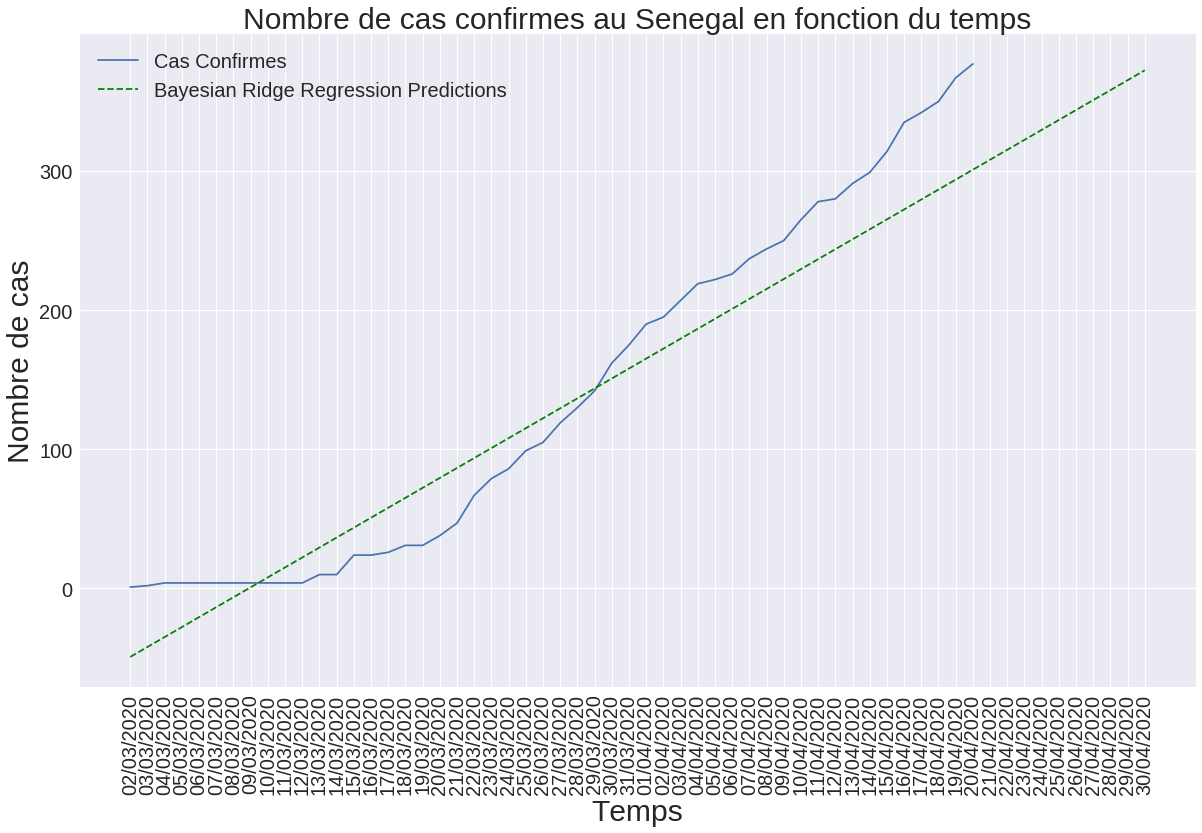

bayesian model future predictions:
          Date  Predictions
50  21/04/2020        308.0
51  22/04/2020        315.0
52  23/04/2020        322.0
53  24/04/2020        330.0
54  25/04/2020        337.0
55  26/04/2020        344.0
56  27/04/2020        351.0
57  28/04/2020        358.0
58  29/04/2020        365.0
59  30/04/2020        372.0


In [10]:
bayes_model('Senegal', df, n=10, mode = 'cum', plot = True)

# Polynomial Regression

In [11]:

def polynom_regression_model(ct, df, n=5, p=2, plot = False):
    """
      This function defines init and run the polynomial regression model
    """
    #Data prep
    cases_df = get_daily_var(ct,df)   
    _, cases_cum, days_since = get_pred_data(cases_df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    poly = PolynomialFeatures(degree = p)
    
    #Split Data
    X_train_cum, X_test_cum, y_train_cum, y_test_cum = train_test_split(days_since, cases_cum, test_size=0.25, shuffle=False)
    
    #fit and init model                                                                   
    X_poly = poly.fit_transform(X_train_cum)
    poly.fit(X_poly, y_train_cum)
    lin2 = LinearRegression()
    lin2.fit(X_poly, y_train_cum)
    cum_poly_pred_future = lin2.predict(poly.fit_transform(future_forcast))
                                                                        
    #ploting_results
    if plot == True:
                                                                        
        plt.figure(figsize=(20, 12))
        plt.plot(future_forcast_dates[:-n], cases_cum, color='blue')
        plt.plot(future_forcast_dates, cum_poly_pred_future, linestyle='dashed', color='green')
        plt.title(f'Nombre de cas confirmes au {ct} en fonction du temps', size=30)
        plt.xlabel('Temps', size=20)
        plt.ylabel('Nombre de cas', size=30)
        plt.legend(['Cas Confirmes', 'polynomial Regression Predictions'], prop={'size': 30})
        plt.xticks(size=20, rotation = 90)
        plt.yticks(size=20)
        plt.show() 
    # Future predictions using Linear Regression 
    print('Polynomial future predictions:')
    zipped =zip(future_forcast_dates, np.round(cum_poly_pred_future) )
    # Converting to list 
    zipped = list(zipped) 
    # Using sorted and lambda 
    res = sorted(zipped, key = lambda x: x[1])
    # printing result \n",
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n))      
                                                                        
    return None

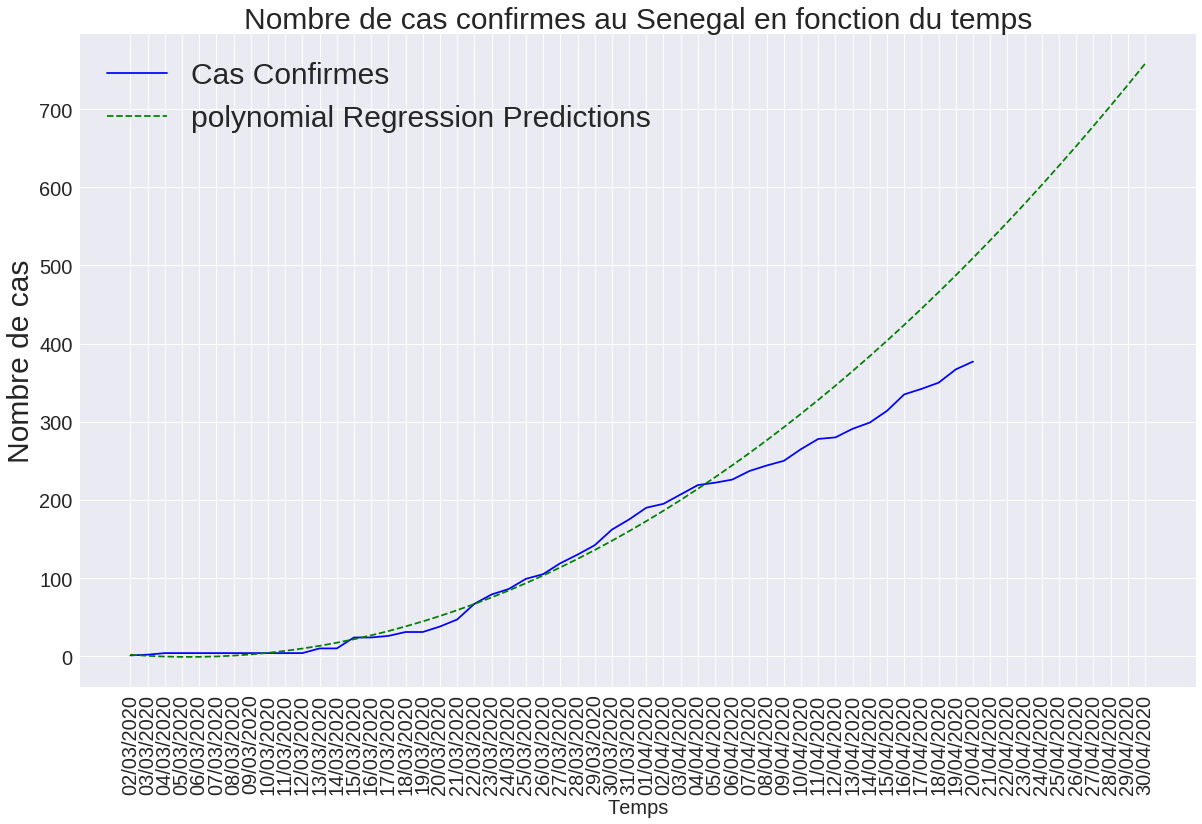

Polynomial future predictions:
          Date Predictions
50  21/04/2020     [532.0]
51  22/04/2020     [555.0]
52  23/04/2020     [579.0]
53  24/04/2020     [603.0]
54  25/04/2020     [628.0]
55  26/04/2020     [653.0]
56  27/04/2020     [678.0]
57  28/04/2020     [704.0]
58  29/04/2020     [731.0]
59  30/04/2020     [758.0]


In [12]:
polynom_regression_model('Senegal', df, n=10, p=2, plot = True)

# Modeling Logistic Growth

Reference

https://jooskorstanje.com/modeling-logistic-growth-corona.html
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2


La croissance logistique est une fonction mathématique qui peut être utilisée dans plusieurs situations. La croissance logistique se caractérise par une croissance croissante au début, mais une croissance décroissante à un stade ultérieur, à mesure que l'on se rapproche d'un maximum. Par exemple, dans le cas du coronavirus, cette limite maximale serait le nombre total de personnes dans le monde, car lorsque tout le monde est malade, la croissance diminuera nécessairement.
Dans d'autres cas d'utilisation de croissance logistique, ce nombre pourrait être la taille d'une population animale qui croît de façon exponentielle jusqu'au moment où leur environnement ne fournit pas suffisamment de nourriture pour tous les animaux et donc la croissance devient plus lente jusqu'à ce qu'une capacité maximale de l'environnement soit atteinte .
La raison d'utiliser la croissance logistique pour modéliser l'épidémie de coronavirus est que les épidémiologistes ont étudié ces types d'épidémies et il est bien connu que la première période d'une épidémie suit la croissance exponentielle et que la période totale peut être modélisée avec une croissance logistique.

In [13]:
def logistic_growth_model(ct, df, n=5, size = 3):
    
    cases_df = get_daily_var(ct,df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    
    # Define funcion with the coefficients to estimate
    def my_logistic(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))
    
    #Randomly initialize the coefficients
    p0 = np.random.exponential(size=3)
    
    # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
    bounds = (0, [100, 3., 1000])
    
    # Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
    x = np.arange(len(cases_df)) + 1
    y = np.array(cases_df.cumsum()['Daily_case'])
    
    (a,b,c),cov = optim.curve_fit(my_logistic, x, y, bounds=bounds, p0=p0)
    
    # Redefine the function with the new a, b and c
    def my_logistic(t):
        return c / (1 + a * np.exp(-b*t))
    plt.figure(figsize=(20,12))
    plt.scatter(future_forcast_dates[0:len(y)], y)
    plt.plot(x, my_logistic(x),color = 'red')
    plt.title('Logistic Model vs Real Observations of Senegal Coronavirus')
    plt.legend([ 'Logistic Model', 'Real data'])
    plt.xlabel('Time')
    plt.ylabel('Infections')
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(20,12))
    plt.scatter(x, y)
    plt.plot(future_forcast_dates, my_logistic(future_forcast),color = 'red')
    plt.title(f'Logistic Model vs Real Observations of {ct} Coronavirus')
    plt.legend([' Predict Logistic Model ', 'Real data'])
    plt.xlabel('Time')
    plt.ylabel('Infections')
    plt.xticks(rotation = 90)
    plt.show()
    
    # The time step at which the growth is fastest
    t_fastest = np.log(a) / b
    t_fastest
    print(np.round(t_fastest))
    future_forcast_dates[27]
    # First way to find the y of the fastest growth moment
    y_fastest = c / 2
    y_fastest
    # Second way to find the y of the fastest growth moment
    print(my_logistic(t_fastest))
    # Future predictions using Linear Regression 
    print('logistic future predictions:')
    zipped =zip(future_forcast_dates, np.round(my_logistic(future_forcast)) )
    # Converting to list 
    zipped = list(zipped) 
    # Using sorted and lambda 
    res = sorted(zipped, key = lambda x: x[1]) 
    # printing result \n",
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n)) 

    return None

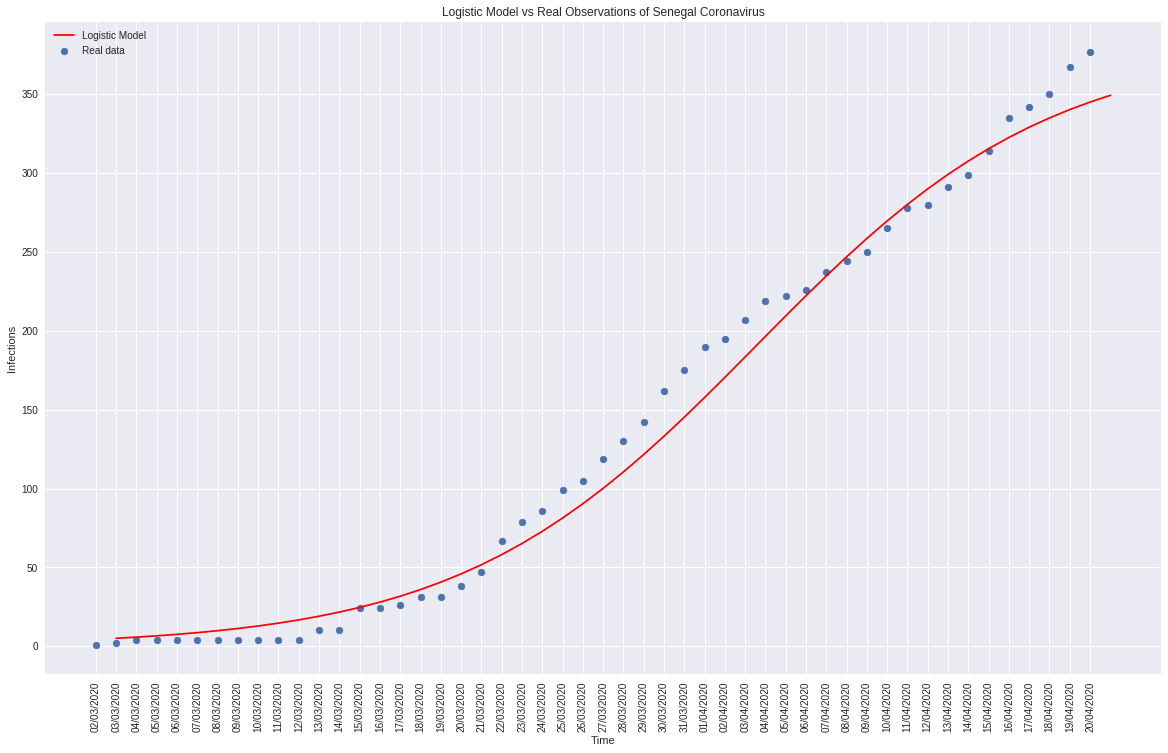

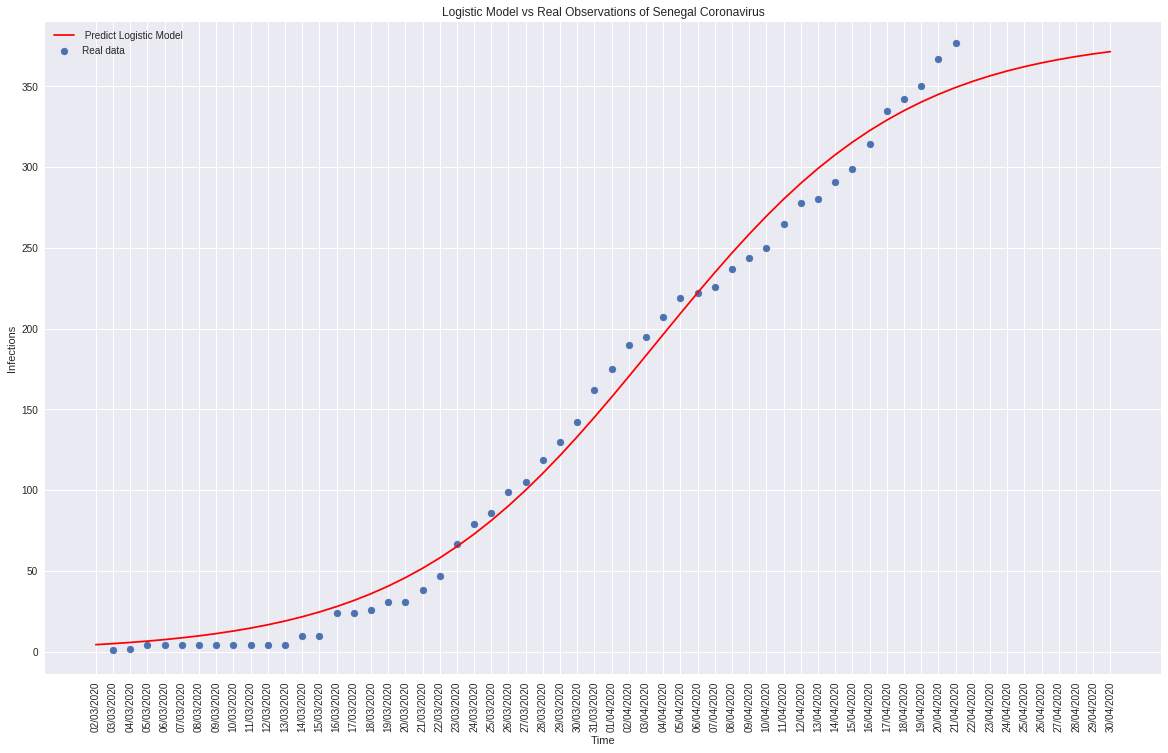

33.0
190.73985188666046
logistic future predictions:
          Date Predictions
50  21/04/2020     [349.0]
51  22/04/2020     [353.0]
52  23/04/2020     [356.0]
53  24/04/2020     [359.0]
54  25/04/2020     [362.0]
55  26/04/2020     [365.0]
56  27/04/2020     [367.0]
57  28/04/2020     [368.0]
58  29/04/2020     [370.0]
59  30/04/2020     [371.0]


In [14]:
logistic_growth_model('Senegal', df, n=10, size = 3)